# Customer Classification Project

- Clean Data
- Build clustering model 
- Model should factor in both aggregate sales patterns and specific items purchased

### Import Libraries and load data

In [1]:
# print_function for compatibility with Python 3
from __future__ import print_function
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
# Load international online transactions data from CSV
df = pd.read_csv('int_online_tx.csv')

### Explore Data

In [3]:
# Dataframe dimensions
df.shape

(35116, 8)

In [4]:
# First 10 rows of data
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


#### Transactions by Country

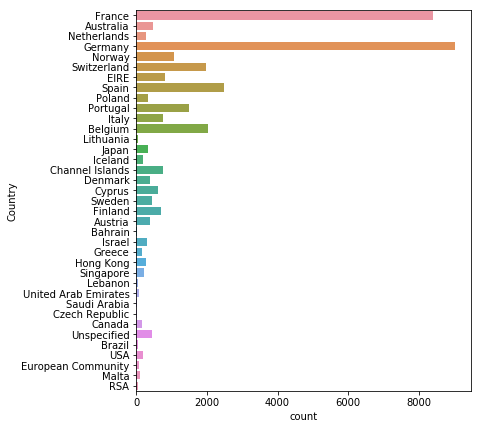

In [5]:
# Make figsize 6x7
plt.figure(figsize=(6,7))

# Bar plot by country
sns.countplot(y='Country', data=df)

### Transaction Level Cleaning

In [6]:
# Missing data by feature
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

In [7]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]

In [8]:
# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()

0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int64

#### Create 'Sales' feature

In [9]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

In [10]:
# Save cleaned transaction-level data
df.to_csv('cleaned_transactions.csv', index=None)

## Feature Engineering

In [11]:
# Aggegrate invoice data
invoice_data = df.groupby('CustomerID').InvoiceNo.agg({ 'total_transactions' : 'nunique' })

# Display invoice data for first 5 customers
invoice_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


- 'total_products' - total number of products purchased
- 'total_unique_products' - number of unique products purchased by each customer
- Name product_data

In [12]:
# Aggregate product data
product_data = df.groupby('CustomerID').StockCode.agg( { 'total_products' : 'count', 
                                                     'total_unique_products' : 'nunique' } )

# Display product data for first 5 customers
product_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


## Aggregate sales data by customer
- 'total_sales' - total sales for each customer
- 'avg_product_value' - average value of products purchased by the customer
- name 'sales_data'

In [13]:
# Roll up sales data
sales_data = df.groupby('CustomerID').Sales.agg( { 'total_sales' : 'sum', 
                                                  'avg_product_value' : 'mean' } )

# Display sales data for first 5 customers
sales_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


### Create Cart Level Aggregation Data

In [14]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID' , 'InvoiceNo']).Sales.agg( { 'cart_value' : 'sum' })

# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 5 CARTS
cart_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91


## Aggregate cart data by customer
- 'avg_cart_value'
- 'min_cart_value'
- 'Max_cart_value'
- agg_cart_data

In [15]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg( { 'avg_cart_value' : 'mean', 
                                                                 'min_cart_value' : 'min',
                                                                 'max_cart_value' : 'max'})

# Display cart data for first 5 CUSTOMERS
agg_cart_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


## Join together the analytics table

In [16]:
# Join together customer-level ABT
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


In [18]:
# Save analytical base table
customer_df.to_csv('analytical_base_table3.csv')

# Dimensionality Reduction

In [19]:
# Read cleaned_transactions.csv
df = pd.read_csv('cleaned_transactions.csv')

In [20]:
# First 10 StockCodes and Descriptions
df[['StockCode', 'Description']].head(10)

,StockCode,Description
0,22728,ALARM CLOCK BAKELIKE PINK
1,22727,ALARM CLOCK BAKELIKE RED
2,22726,ALARM CLOCK BAKELIKE GREEN
3,21724,PANDA AND BUNNIES STICKER SHEET
4,21883,STARS GIFT TAPE
5,10002,INFLATABLE POLITICAL GLOBE
6,21791,VINTAGE HEADS AND TAILS CARD GAME
7,21035,SET/2 RED RETROSPOT TEA TOWELS
8,22326,ROUND SNACK BOXES SET OF4 WOODLAND
9,22629,SPACEBOY LUNCH BOX


In [21]:
# Number of unique items
len(df.StockCode.unique())

2574

### Check data Roll up

In [22]:
# Create toy_df
toy_df = df[df.CustomerID.isin([14566, 17844])]

# Display toy_df
toy_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
19250,563900,85099C,JUMBO BAG BAROQUE BLACK WHITE,200,8/21/11 11:05,1.79,14566,Channel Islands,358.00
19251,563900,85099B,JUMBO BAG RED RETROSPOT,200,8/21/11 11:05,1.79,14566,Channel Islands,358.00
19252,563900,23199,JUMBO BAG APPLES,200,8/21/11 11:05,1.79,14566,Channel Islands,358.00
19253,563900,22386,JUMBO BAG PINK POLKADOT,200,8/21/11 11:05,1.79,14566,Channel Islands,358.00
19851,564428,21993,FLORAL FOLK STATIONERY SET,12,8/25/11 11:27,1.25,17844,Canada,15.00
19852,564428,23295,SET OF 12 MINI LOAF BAKING CASES,8,8/25/11 11:27,0.83,17844,Canada,6.64
19853,564428,23293,SET OF 12 FAIRY CAKE BAKING CASES,16,8/25/11 11:27,0.83,17844,Canada,13.28
19854,564428,23296,SET OF 6 TEA TIME BAKING CASES,8,8/25/11 11:27,1.25,17844,Canada,10.00
19855,564428,23294,SET OF 6 SNACK LOAF BAKING CASES,8,8/25/11 11:27,0.83,17844,Canada,6.64


Create dataframe dummy variables for 'StockCode'

In [23]:
# Get toy_item_dummies
toy_item_dummies = pd.get_dummies( toy_df.StockCode )

# Add CustomerID to toy_item_dummies
toy_item_dummies['CustomerID'] = toy_df.CustomerID

# Display toy_item_dummies
toy_item_dummies

,21993,22386,23199,23293,23294,23295,23296,85099B,85099C,CustomerID
19250,0,0,0,0,0,0,0,0,1,14566
19251,0,0,0,0,0,0,0,1,0,14566
19252,0,0,1,0,0,0,0,0,0,14566
19253,0,1,0,0,0,0,0,0,0,14566
19851,1,0,0,0,0,0,0,0,0,17844
19852,0,0,0,0,0,1,0,0,0,17844
19853,0,0,0,1,0,0,0,0,0,17844
19854,0,0,0,0,0,0,1,0,0,17844
19855,0,0,0,0,1,0,0,0,0,17844


### Aggregate this data at customer level

In [24]:
# Create toy_item_data by aggregating at customer level
toy_item_data = toy_item_dummies.groupby('CustomerID').sum()

# Display toy_item_data
toy_item_data

,21993,22386,23199,23293,23294,23295,23296,85099B,85099C
CustomerID,,,,,,,,,
14566,0,1,1,0,0,0,0,1,1
17844,1,0,0,1,1,1,1,0,0


## Dummies for full dataset

In [25]:
# Get item_dummies
item_dummies = pd.get_dummies( df.StockCode )

# Add CustomerID to item_dummies
item_dummies['CustomerID'] = df.CustomerID

# Display first 5 rows of item_dummies
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583


In [26]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


In [27]:
# Total times each item was purchased
item_data.sum()

10002        12
10120         1
10125        13
10133         5
10135         4
11001         8
15034         5
15036        19
15039         3
15044A        6
15044B        3
15044C        2
15044D        4
15056BL      50
15056N       35
15056P       24
15058A        9
15058B        8
15058C        4
15060B       12
16008        11
16011         3
16012         4
16014        10
16016        16
16045         8
16048         8
16054         2
16156L        6
16156S       12
           ... 
90098         1
90099         2
90108         1
90114         1
90120B        1
90145         2
90160A        1
90160B        1
90160C        1
90160D        1
90161B        1
90161C        1
90161D        1
90162A        1
90162B        1
90164A        1
90170         1
90173         1
90184B        1
90184C        1
90192         1
90201A        1
90201B        3
90201C        2
90201D        1
90202D        1
90204         1
C2            6
M            34
POST       1055
Length: 2574, dtype: int

In [28]:
# Save item_data.csv
item_data.to_csv('item_data2.csv')

## Reduce Dimensionality w Thresholds

In [29]:
# Display most popular 20 items
item_data.sum().sort_values().tail(20)

22961      114
22630      115
22139      117
21080      122
85099B     123
20726      123
20719      128
20750      132
23084      140
20725      141
21212      143
22551      158
22629      160
22328      166
21731      169
22556      179
22554      197
22423      222
22326      271
POST      1055
dtype: int64

In [30]:
# Get list of StockCodes for the 20 most popular items
top_20_items = item_data.sum().sort_values().tail(20).index

top_20_items

Index(['22961', '22630', '22139', '21080', '85099B', '20726', '20719', '20750',
       '23084', '20725', '21212', '22551', '22629', '22328', '21731', '22556',
       '22554', '22423', '22326', 'POST'],
      dtype='object')

In [31]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]

# Shape of remaining dataframe
top_20_item_data.shape

(414, 20)

In [32]:
# Display first 5 rows of top_20_item_data
top_20_item_data.head()

,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [36]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('threshold_item_data.csv')

# Principle Component Analysis

In [37]:
# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler
# PCA from Scikit-Learn (added later)
from sklearn.decomposition import PCA

In [38]:
# Read item_data.csv
item_data = pd.read_csv('item_data2.csv', index_col=0)

In [39]:
# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

# Display first 5 rows of item_data_scaled
item_data_scaled[:5]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

In [40]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [41]:
# Generate new features
PC_items = pca.transform(item_data_scaled)

# Display first 5 rows
PC_items[:5]

array([[ 5.87614052e+00,  4.82891689e+00, -4.95545069e-01, ...,
        -6.62646278e-04, -4.43629806e-05,  2.35922393e-15],
       [-4.21983747e+00,  1.22621722e+00, -1.88191211e+00, ...,
        -2.11471782e-04, -2.69154340e-04,  3.49427518e-15],
       [-1.26084676e+00,  2.38766371e+00, -7.31483440e-02, ...,
         2.57750179e-04, -2.05682324e-04,  2.70963807e-15],
       [-4.92931983e+00, -7.14858724e-01, -1.58093026e+00, ...,
        -1.98603886e-03,  9.92316312e-05,  4.12690715e-15],
       [-2.05311348e+00,  2.11095022e+00,  1.84807021e-01, ...,
        -3.43415269e-04, -1.32981672e-04,  4.74620343e-15]])

## Explained Variance

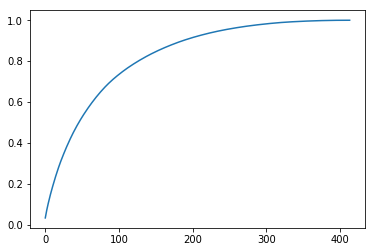

In [42]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [43]:
# How much variance we'd capture with the first 125 components
cumulative_explained_variance[124]

0.7955069032205403

In [44]:
# Initialize PCA transformation, only keeping 125 components
pca = PCA(n_components=125)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 125)

In [45]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.876145,4.828969,-0.495552,3.093880,-0.633669,-11.534177,2.161952,7.116984,5.335991,4.424495,4.636931,2.316333,12.310756,1.986696,-11.431489,5.617824,-2.177511,7.665529,-12.135829,-16.049006,-5.949773,7.814983,40.518080,-35.574601,-17.556206,6.869156,20.887324,2.296973,-26.158906,-32.580779,7.882022,12.355540,6.825529,-32.956717,-4.408941,-17.237729,-11.272848,-14.487706,-2.771591,4.737233,-6.984331,-1.460354,10.602471,1.245260,3.093842,5.325570,-0.415038,-1.761014,-6.335748,3.066823,...,2.357529,2.454337,-1.028802,-1.615899,-1.959748,1.403130,0.528728,-1.282580,-2.042588,-3.632817,0.420557,-1.797067,0.708809,0.266041,1.184124,-1.702471,0.854744,0.333887,-0.177699,0.885364,-0.350317,-0.517207,0.151963,0.399105,0.249574,-0.809320,1.514407,-0.101054,0.149137,-0.546162,0.500577,0.480298,-1.644829,0.231027,0.382392,0.520917,0.868741,-0.094808,-0.747757,0.269959,0.065853,0.051871,0.123760,-0.413667,0.362235,-0.223727,0.398719,0.323106,0.084000,0.559487
12348,-4.219837,1.226215,-1.881862,-0.174384,0.817813,1.161040,-0.871451,-0.846329,0.459978,0.854436,-0.401684,0.982045,-1.104177,0.769516,-0.092897,-0.313350,-0.449670,1.205793,0.380638,-0.469707,0.183754,0.054215,0.498068,0.374143,1.225401,-0.773007,-0.271127,0.853399,-0.371394,-0.572092,1.015064,-0.583829,0.951021,-0.730489,0.355050,-0.387238,-0.297990,0.390952,0.156667,0.332220,-0.459652,0.709079,1.194278,-0.212513,-0.874143,-0.048253,-0.417126,1.627896,-0.448879,0.454888,...,-1.081402,-0.945384,-0.248760,-0.463957,-0.067121,0.277421,-0.715416,-0.519271,0.765187,0.091737,-0.096908,0.103481,-1.937998,0.104650,-0.395154,-0.586611,0.121219,0.915176,-0.613238,1.137698,-0.447173,-0.287402,0.929596,1.116429,-0.080777,0.680622,-0.068404,-0.853125,-2.208159,0.613714,1.379680,0.203454,0.952373,-1.226848,0.819524,-1.017552,0.017259,-0.313641,-1.177993,-0.352647,-1.841582,-0.637288,-0.936221,0.500061,-0.197669,0.158937,-0.044807,-2.541793,-0.386836,-1.296982
12349,-1.260843,2.387649,-0.072979,-1.119311,-0.034174,-3.715643,-0.342541,-0.149156,-0.790718,-0.378511,1.569696,0.183383,0.223660,-0.050490,3.178604,-0.512408,-1.843402,0.383602,0.317803,-0.000893,-0.415641,0.457991,-0.788319,1.751251,-1.482928,0.752224,-0.919444,0.771572,0.498848,-1.339542,0.281939,0.674910,0.093571,-0.217107,-0.660305,-1.543944,0.767321,-1.426838,-0.087763,-0.916503,0.100568,-0.093095,-0.154728,0.693873,1.386419,-0.236556,-0.080760,0.219304,0.809229,1.676577,...,2.214266,-0.914323,1.788393,0.407746,1.117883,-0.543854,-0.664155,0.798763,1.392759,-0.231474,1.131485,0.830932,-2.316579,-2.336444,0.355573,-2.944342,-0.187867,-1.753432,-1.556116,-1.495006,0.148460,-0.708290,2.448015,-1.453290,0.494505,2.723414,-1.931131,-1.918782,0.697474,-0.368659,-0.172651,0.609252,-0.568053,-2.281610,1.498750,0.434919,1.211073,2.894247,2.562607,-0.191530,1.639428,-2.160883,1.912091,0.610715,-2.921619,0.109994,1.353302,0.859905,2.817094,0.434365
12350,-4.929314,-0.714800,-1.580925,-0.469804,-0.116314,0.647900,0.112914,-1.336481,1.546917,-1.189974,-0.213376,1.056956,-0.475619,0.856420,-1.305984,0.242886,0.267441,1.951259,-0.227971,0.569370,-0.188295,0.904750,1.364224,0.179422,-0.260739,-0.169759,-0.681635,1.085529,-0.155481,-0.397192,0.240160,0.634808,-1.450088,-0.183800,-0.317240,-0.303980,-1.359526,-0.002606,0.574719,-0.252554,0.589534,-0.213948,0.276861,0.541035,-0.523147,-0.101609,-1.468731,-0.134573,0.15

In [46]:
# Save pca_item_data.csv
items_pca.to_csv('pca_item_data.csv')

In [47]:
# Scikit-Learn's make_pipeline function
from sklearn.pipeline import make_pipeline

# Scikit-Learn's StandardScaler
from sklearn.preprocessing import StandardScaler

# Scikit-Learn's KMeans algorithm (added later)
from sklearn.cluster import KMeans

In [48]:
# Import analytical base table
base_df = pd.read_csv('analytical_base_table3.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('pca_item_data.csv', index_col=0)

In [49]:
# Print shape of each dataframe
print( base_df.shape )
print( threshold_item_data.shape )
print( pca_item_data.shape )

(414, 8)
(414, 20)
(414, 125)


# K-Means Clustering

In [50]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)

# Display first 5 rows of threshold_df
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [51]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876145,4.828969,-0.495552,3.093880,-0.633669,-11.534177,2.161952,7.116984,5.335991,4.424495,4.636931,2.316333,12.310756,1.986696,-11.431489,5.617824,-2.177511,7.665529,-12.135829,-16.049006,-5.949773,7.814983,40.518080,-35.574601,-17.556206,6.869156,20.887324,2.296973,-26.158906,-32.580779,7.882022,12.355540,6.825529,-32.956717,-4.408941,-17.237729,-11.272848,-14.487706,-2.771591,4.737233,-6.984331,-1.460354,...,2.357529,2.454337,-1.028802,-1.615899,-1.959748,1.403130,0.528728,-1.282580,-2.042588,-3.632817,0.420557,-1.797067,0.708809,0.266041,1.184124,-1.702471,0.854744,0.333887,-0.177699,0.885364,-0.350317,-0.517207,0.151963,0.399105,0.249574,-0.809320,1.514407,-0.101054,0.149137,-0.546162,0.500577,0.480298,-1.644829,0.231027,0.382392,0.520917,0.868741,-0.094808,-0.747757,0.269959,0.065853,0.051871,0.123760,-0.413667,0.362235,-0.223727,0.398719,0.323106,0.084000,0.559487
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226215,-1.881862,-0.174384,0.817813,1.161040,-0.871451,-0.846329,0.459978,0.854436,-0.401684,0.982045,-1.104177,0.769516,-0.092897,-0.313350,-0.449670,1.205793,0.380638,-0.469707,0.183754,0.054215,0.498068,0.374143,1.225401,-0.773007,-0.271127,0.853399,-0.371394,-0.572092,1.015064,-0.583829,0.951021,-0.730489,0.355050,-0.387238,-0.297990,0.390952,0.156667,0.332220,-0.459652,0.709079,...,-1.081402,-0.945384,-0.248760,-0.463957,-0.067121,0.277421,-0.715416,-0.519271,0.765187,0.091737,-0.096908,0.103481,-1.937998,0.104650,-0.395154,-0.586611,0.121219,0.915176,-0.613238,1.137698,-0.447173,-0.287402,0.929596,1.116429,-0.080777,0.680622,-0.068404,-0.853125,-2.208159,0.613714,1.379680,0.203454,0.952373,-1.226848,0.819524,-1.017552,0.017259,-0.313641,-1.177993,-0.352647,-1.841582,-0.637288,-0.936221,0.500061,-0.197669,0.158937,-0.044807,-2.541793,-0.386836,-1.296982
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260843,2.387649,-0.072979,-1.119311,-0.034174,-3.715643,-0.342541,-0.149156,-0.790718,-0.378511,1.569696,0.183383,0.223660,-0.050490,3.178604,-0.512408,-1.843402,0.383602,0.317803,-0.000893,-0.415641,0.457991,-0.788319,1.751251,-1.482928,0.752224,-0.919444,0.771572,0.498848,-1.339542,0.281939,0.674910,0.093571,-0.217107,-0.660305,-1.543944,0.767321,-1.426838,-0.087763,-0.916503,0.100568,-0.093095,...,2.214266,-0.914323,1.788393,0.407746,1.117883,-0.543854,-0.664155,0.798763,1.392759,-0.231474,1.131485,0.830932,-2.316579,-2.336444,0.355573,-2.944342,-0.187867,-1.753432,-1.556116,-1.495006,0.148460,-0.708290,2.448015,-1.453290,0.494505,2.723414,-1.931131,-1.918782,0.697474,-0.368659,-0.172651,0.609252,-0.568053,-2.281610,1.498750,0.434919,1.211073,2.894247,2.562607,-0.191530,1.639428,-2.160883,1.912091,0.610715,-2.921619,0.109994,1.353302,0.859905,2.817094,0.434365
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929314,-0.714800,-1.580925,-0.469804,-0.116314,0.647900,0.112914,-1.336481,1.546917,-1.189974,-0.213376,1.056956,-0.475619,0.856420,-1.305984,0.242886,0.267441,1.951259,-0.227971,0.569370,-0.188295,0.904750,1.364224,0.179422,-0.260739,-0.169759,-0.681635,1.085529,-0.155481,-0.397192,0.240160,0.634808,-1.450088,-0.183800,-0.317240,-0.303980,-1.359526,-0.002606,0.574719,-0.252554,0.589534,

In [52]:
from sklearn.cluster import KMeans

In [53]:
# First 5 observations of base_df
base_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


In [54]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))

In [55]:
# Fit K-Means pipeline
k_means.fit(base_df)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0))])

In [56]:
# Save clusters to base_df
base_df['cluster'] = k_means.predict(base_df)

# Display first 5 rows of base_df
base_df.head()

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,cluster
CustomerID,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,1
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0


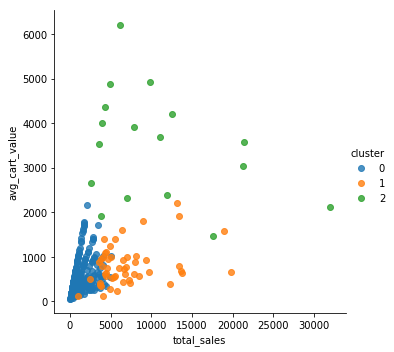

In [57]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=base_df, fit_reg=False)

# Threshold DF Clustering

In [58]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))

In [59]:
# Fit K-Means pipeline
k_means.fit(threshold_df)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0))])

In [60]:
# Save clusters to threshold_df
threshold_df['cluster'] = k_means.predict(threshold_df)

# Display first 5 rows of threshold_df
threshold_df.head()

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5,2


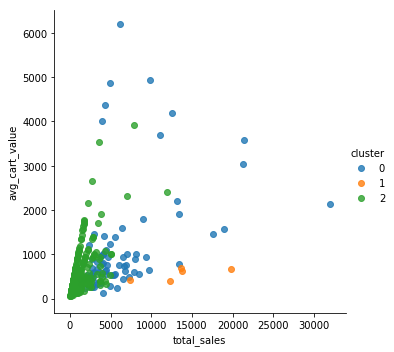

In [61]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)


# PCA DF Clusters

In [62]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))

In [63]:
# Fit K-Means pipeline
k_means.fit(pca_df)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0))])

In [64]:
# Save clusters to pca_df
pca_df['cluster'] = k_means.predict(pca_df)

# Display first 5 rows of pca_df
pca_df.head()

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876145,4.828969,-0.495552,3.093880,-0.633669,-11.534177,2.161952,7.116984,5.335991,4.424495,4.636931,2.316333,12.310756,1.986696,-11.431489,5.617824,-2.177511,7.665529,-12.135829,-16.049006,-5.949773,7.814983,40.518080,-35.574601,-17.556206,6.869156,20.887324,2.296973,-26.158906,-32.580779,7.882022,12.355540,6.825529,-32.956717,-4.408941,-17.237729,-11.272848,-14.487706,-2.771591,4.737233,-6.984331,-1.460354,...,2.454337,-1.028802,-1.615899,-1.959748,1.403130,0.528728,-1.282580,-2.042588,-3.632817,0.420557,-1.797067,0.708809,0.266041,1.184124,-1.702471,0.854744,0.333887,-0.177699,0.885364,-0.350317,-0.517207,0.151963,0.399105,0.249574,-0.809320,1.514407,-0.101054,0.149137,-0.546162,0.500577,0.480298,-1.644829,0.231027,0.382392,0.520917,0.868741,-0.094808,-0.747757,0.269959,0.065853,0.051871,0.123760,-0.413667,0.362235,-0.223727,0.398719,0.323106,0.084000,0.559487,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226215,-1.881862,-0.174384,0.817813,1.161040,-0.871451,-0.846329,0.459978,0.854436,-0.401684,0.982045,-1.104177,0.769516,-0.092897,-0.313350,-0.449670,1.205793,0.380638,-0.469707,0.183754,0.054215,0.498068,0.374143,1.225401,-0.773007,-0.271127,0.853399,-0.371394,-0.572092,1.015064,-0.583829,0.951021,-0.730489,0.355050,-0.387238,-0.297990,0.390952,0.156667,0.332220,-0.459652,0.709079,...,-0.945384,-0.248760,-0.463957,-0.067121,0.277421,-0.715416,-0.519271,0.765187,0.091737,-0.096908,0.103481,-1.937998,0.104650,-0.395154,-0.586611,0.121219,0.915176,-0.613238,1.137698,-0.447173,-0.287402,0.929596,1.116429,-0.080777,0.680622,-0.068404,-0.853125,-2.208159,0.613714,1.379680,0.203454,0.952373,-1.226848,0.819524,-1.017552,0.017259,-0.313641,-1.177993,-0.352647,-1.841582,-0.637288,-0.936221,0.500061,-0.197669,0.158937,-0.044807,-2.541793,-0.386836,-1.296982,0
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260843,2.387649,-0.072979,-1.119311,-0.034174,-3.715643,-0.342541,-0.149156,-0.790718,-0.378511,1.569696,0.183383,0.223660,-0.050490,3.178604,-0.512408,-1.843402,0.383602,0.317803,-0.000893,-0.415641,0.457991,-0.788319,1.751251,-1.482928,0.752224,-0.919444,0.771572,0.498848,-1.339542,0.281939,0.674910,0.093571,-0.217107,-0.660305,-1.543944,0.767321,-1.426838,-0.087763,-0.916503,0.100568,-0.093095,...,-0.914323,1.788393,0.407746,1.117883,-0.543854,-0.664155,0.798763,1.392759,-0.231474,1.131485,0.830932,-2.316579,-2.336444,0.355573,-2.944342,-0.187867,-1.753432,-1.556116,-1.495006,0.148460,-0.708290,2.448015,-1.453290,0.494505,2.723414,-1.931131,-1.918782,0.697474,-0.368659,-0.172651,0.609252,-0.568053,-2.281610,1.498750,0.434919,1.211073,2.894247,2.562607,-0.191530,1.639428,-2.160883,1.912091,0.610715,-2.921619,0.109994,1.353302,0.859905,2.817094,0.434365,0
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929314,-0.714800,-1.580925,-0.469804,-0.116314,0.647900,0.112914,-1.336481,1.546917,-1.189974,-0.213376,1.056956,-0.475619,0.856420,-1.305984,0.242886,0.267441,1.951259,-0.227971,0.569370,-0.188295,0.904750,1.364224,0.179422,-0.260739,-0.169759,-0.681635,1.085529,-0.155481,-0.397192,0.240160,0.634808,-1.450088,-0.183800,-0.317240,-0.303980,-1.359526,-0.002606,0.574719,-0.252554,0.589534,-0.213948,...,-0.33

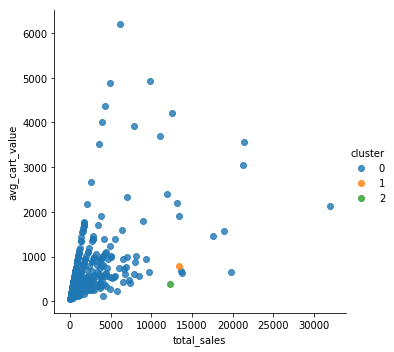

In [65]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

# Model Comparison

In [66]:
# Check all indices are identical
print( all( base_df.index == threshold_df.index ) )
print( all( base_df.index == pca_df.index) )

True
True


In [67]:
# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

In [68]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(base_df.cluster, threshold_df.cluster)

0.6021354951782343

In [69]:
# Similary between threshold_df.cluster and base_df.cluster
adjusted_rand_score(threshold_df.cluster, base_df.cluster)

0.6021354951782343

In [70]:
# Similary between base_df.cluster and pca_df.cluster
adjusted_rand_score(base_df.cluster, pca_df.cluster)

0.039644551618711936